In [1]:
import pandas as pd
import numpy as np
from glob import glob
from subprocess import check_output
from datetime import date
from datetime import *

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

import pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

2.1.0


## Download and check covid data

In [2]:
def modify_date(date):
    m, d, y = list(map(int, date.split('/')))
    date_vec = [y, m, d]
    return '20' + '-'.join([str(x).zfill(2) for x in date_vec])

In [3]:
# ======================================== Download Raw from JHU ========================================
url_case = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
df_case = pd.read_csv(url_case).dropna()
df_death = pd.read_csv(url_death).dropna()

print(f'JHU case data shape = {df_case.shape}')
print(f'JHU death data shape = {df_death.shape}')

dates_case = sorted([modify_date(col) for col in df_case.columns if col.endswith('/20') or col.endswith('/21')])
dates_death = sorted([modify_date(col) for col in df_death.columns if col.endswith('/20') or col.endswith('/21')])

csv_case_fname = url_case.split('/')[-1][:-4] + '_' + dates_case[-1] + '.csv'
csv_death_fname = url_death.split('/')[-1][:-4] + '_' + dates_case[-1] + '.csv'

existing_case_csv = glob('pipeline_data/time_series_covid19_confirmed_US*csv')
existing_death_csv = glob('pipeline_data/time_series_covid19_deaths_US*csv')
if len(existing_case_csv) > 0:
    for csv in existing_case_csv:
        check_output(f'rm {csv}', shell=True)
if len(existing_death_csv) > 0:
    for csv in existing_death_csv:
        check_output(f'rm {csv}', shell=True)    

df_case.to_csv(f'pipeline_data/{csv_case_fname}', index=False)
df_death.to_csv(f'pipeline_data/{csv_death_fname}', index=False)


# ======================================== Get weekly data ========================================
start = '2020-04-04'
end = date.today()
dates_ = pd.date_range(start, end, freq='7D')


df_case.rename(
    columns={col: modify_date(col) for col in df_case.columns if col.endswith('/20') or col.endswith('/21')}, 
    inplace=True)
df_death.rename(
    columns={col: modify_date(col) for col in df_death.columns if col.endswith('/20') or col.endswith('/21')}, 
    inplace=True)

df_death['FIPS'] = df_death['FIPS'].apply(lambda x: str(int(x)).zfill(5))
df_death = df_death.rename(columns={'FIPS': 'fips'}).set_index('fips')
df_death = df_death.drop([
    'UID', 'iso2', 'iso3', 'code3',
    'Admin2', 'Province_State', 'Country_Region', 
    'Lat', 'Long_', 'Combined_Key'], axis=1)
df_death['2020-01-21'] = 0

df_case['FIPS'] = df_case['FIPS'].apply(lambda x: str(int(x)).zfill(5))
df_case = df_case.rename(columns={'FIPS': 'fips'}).set_index('fips')
df_case = df_case.drop([
    'UID', 'iso2', 'iso3', 'code3',
    'Admin2', 'Province_State', 'Country_Region', 
    'Lat', 'Long_', 'Combined_Key'], axis=1)
df_case['2020-01-21'] = 0

dates = sorted(list(set(df_case.columns.values).intersection([str(d.date()) for d in dates_])))
cols = ['2020-01-21'] + dates
df_case_step = df_case[cols]\
    .rename(columns={col: f'case{i - 1}' for i, col in enumerate(cols)})\
    .diff(axis=1).dropna(axis=1)
df_death_step = df_death[cols]\
    .rename(columns={col: f'death{i - 1}' for i, col in enumerate(cols)})\
    .diff(axis=1).dropna(axis=1)

df_covid = pd.concat([df_case_step, df_death_step], axis=1)
df_covid[df_covid < 0] = 0
df_covid[f'total_case'] = df_case[dates_case[-1]]
df_covid[f'total_death'] = df_death[dates_death[-1]]

with open('pipeline_data/steps.dat', 'w') as handle:
    handle.write(' '.join(cols[1:]))
    
# cleanup and save
existing_data_covid_csv = glob('pipeline_data/data_covid_????-??-??.csv')

if len(existing_data_covid_csv) > 0:
    for csv in existing_data_covid_csv:
        check_output(f'rm {csv}', shell=True)
        
df_covid.to_csv(f'pipeline_data/data_covid_{dates_case[-1]}.csv')

JHU case data shape = (3324, 331)
JHU death data shape = (3324, 332)


## Load non-covid data and combine

In [4]:
df_non_covid = pd.read_csv('pipeline_data/data_non-covid.csv', dtype={'fips': str}).set_index('fips')
df = df_non_covid.join(df_covid)

# cleanup and save
existing_data_csv = glob('pipeline_data/data_????-??-??.csv')
if len(existing_data_csv) > 0:
    for csv in existing_data_csv:
        check_output(f'rm {csv}', shell=True)  

df.to_csv(f'pipeline_data/data_{dates_case[-1]}.csv')

## Run GLM


In [5]:
with open('pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
    
ns = len(steps)

steps_c = [f'case{i}' for i in range(ns)]
steps_d = [f'death{i}' for i in range(ns)]
steps_ = steps_c + steps_d

data_fname = glob('pipeline_data/data_????-??-??.csv')[0]
last_date = data_fname.split('/')[-1][:-4].split('_')[-1]
print(f'last date = {last_date}')
steps_c = steps_c + [f'total_case']
steps_d = steps_d + [f'total_death']
steps_ = steps_c + steps_d

df = pd.read_csv(data_fname, dtype={'fips': str}).set_index('fips')

df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk_flu',
    'urban_risk'
]

df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

cov_prefix = 'population+perc_65yrs+perc_minority+perc_black+perc_hispanic+perc_poverty+income+'
cov = cov_prefix + 'perc_urban_pop+risk_flu+urban_risk'

last date = 2020-12-06


### GLM for case

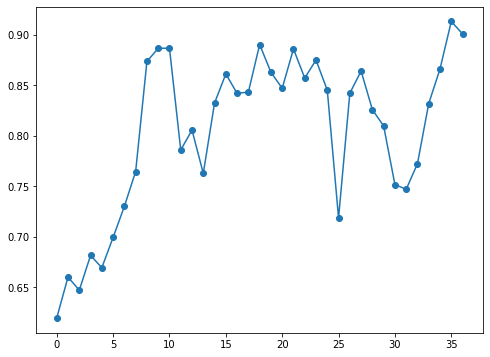

In [6]:
dfs_case = []
cors = []
for i in range(len(steps_c)):
    cur = steps_c[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    # print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()
    
    dfs_case.append(pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0])
    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

### GLM for death

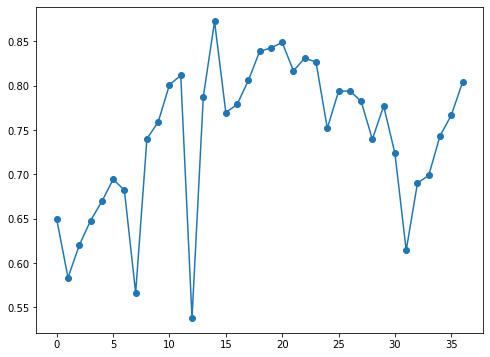

In [7]:
dfs_death = []
cors = []
for i in range(len(steps_d)):
    cur = steps_d[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    # print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()
    
    dfs_death.append(pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0])

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

## Forecast

In [8]:
csv_fname = glob('pipeline_data/data_????-??-??_glm.csv')[0]
df = pd.read_csv(csv_fname, dtype={'fips': str}).set_index('fips')
df.head()

case0  case1  case2  case3  case4  case5  case6  case7  case8  case9  \
fips                                                                          
01001   12.0    7.0    6.0   11.0   11.0   16.0   45.0   48.0   60.0   48.0   
01003   34.0   36.0   40.0   45.0   30.0   34.0   42.0   19.0   12.0   29.0   
01005    3.0    7.0    8.0   16.0    9.0   14.0   24.0   27.0   47.0   41.0   
01007    4.0    9.0   13.0    8.0    7.0    4.0    7.0    7.0   15.0    5.0   
01009   12.0    3.0    9.0   12.0    6.0    5.0    2.0    3.0   13.0   11.0   

       ...  death27_glm  death28_glm  death29_glm  death30_glm  death31_glm  \
fips   ...                                                                    
01001  ...         1.51         1.41         1.89         1.93         2.58   
01003  ...         2.28         2.69         3.30         3.21         3.52   
01005  ...         0.89         0.66         0.71         0.58         1.07   
01007  ...         0.76         0.61         0.79         0.84         1.30   
01009  ...         0.62         0.64         0.80         0.89         1.08   

       death32_glm  death33_glm  death34_glm  death35_glm  total_death_glm  
fips                                                                        
01001         2.54         3.32         2.94         4.43            58.67  
01003         4.07         5.29         5.24         7.84            79.47  
01005         0.68         0.85         0.66         0.95            44.85  
01007         1.06         1.32         1.13         1.64            23.23  
01009         1.07         1.22         1.16         1.64            11.31  

[5 rows x 158 columns]

### Functions

In [9]:
class tfRegr:
    
    def __init__(self, 
                 epoch=100, 
                 verbose=False, 
                 validation_split=0.2, 
                 learning_rate=.1):
        
        self.normalizer = preprocessing.Normalization()
        self.ep = epoch
        self.vb = verbose
        self.vs = validation_split
        self.lr = learning_rate
    
    def fit(self, X, y):
        self.normalizer.adapt(X)

        self.model = tf.keras.Sequential([
            self.normalizer,
            layers.Dense(units=1)
        ])

        self.model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=self.lr),
            loss='mean_absolute_error'
        )

        self.history = self.model.fit(
            X, y,
            epochs=self.ep,
            verbose=self.vb, # logging
            validation_split=self.vs # Calculate validation results on a fraction of the training data
        )
        return self.model

## Forecast for case

In [10]:
num_runs = 1

In [11]:
def predict(df, cur_idx):

    regrs = {
        'RF': RandomForestRegressor(min_samples_split=2), 
        'ET': ExtraTreesRegressor(min_samples_split=2), 
        'TF': tfRegr(),
    }
    
    cur = f'case{cur_idx}'

    glm = [f'case{cur_idx - 1}_glm', f'case{cur_idx}_glm'] 
    cols = [f'case{cur_idx - 1}'] + glm
    X, y = df[cols].values, df[cur].values 
    
    
    for name, regr in regrs.items():
        regr = regr.fit(X, y)

        #================ Evaluation ===============START
        y_pred = regr.predict(X).flatten()
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(((y - y_pred) ** 2).mean())
        print(f'\t{name}: r2 = {r2:.3f}, rmse = {rmse:.3f}')
        #================ Evaluation ===============START
        
        cols = [cur] + glm
        df[cur + f'_{name}_1'] = regr.predict(df[cols].values).flatten()
        
        cols = [cur + f'_{name}_1'] + glm
        df[cur + f'_{name}_2'] = regr.predict(df[cols].values).flatten()
    
    prd_cols_1 = [col for col in df.columns if col.endswith('_1')]
    prd_cols_2 = [col for col in df.columns if col.endswith('_2')]
    prd_1 = df[prd_cols_1].mean(axis=1).values
    prd_2 = df[prd_cols_2].mean(axis=1).values
    
    df.drop(prd_cols_1 + prd_cols_2, axis=1, inplace=True)
    
    return prd_1, prd_2

## Forecast Runs
cur_idx = len(steps) - 1
print(steps[cur_idx])

prds_1, prds_2 = [], []

for r in range(num_runs):
    print(f'run = {r}')
    prd_1, prd_2 = predict(df, cur_idx)
    prds_1.append(prd_1)
    prds_2.append(prd_2)

## Prepare for submission

# target end dates
cur_dt = datetime.strptime(steps[cur_idx], '%Y-%m-%d')
fc_dt = (cur_dt + timedelta(days=1)).date()
nxt_dt_1 = (cur_dt + timedelta(days=7)).date()
nxt_dt_2 = (cur_dt + timedelta(days=14)).date()
nxt_dts = [nxt_dt_1, nxt_dt_2]

# quantiles
qs = [.025, .1, .25, .5, .75, .9, .975]

df_county_prd_1 = pd.DataFrame(data=np.array(prds_1).T, index=df.index, columns=range(num_runs))
df_county_prd_2 = pd.DataFrame(data=np.array(prds_2).T, index=df.index, columns=range(num_runs))
county_dfs = [df_county_prd_1, df_county_prd_2]

### County

forecast_dfs = []

for i, county_df in enumerate(county_dfs):
    w = i + 1
    csv_fname = f'results/{steps[cur_idx]}_county_case_{w}-wk_{num_runs}.csv'
    county_df.to_csv(csv_fname, float_format='%.2f')
    
    # ========================= Point esitmate =========================START
    df_point = county_df.mean(axis=1).reset_index()\
        .rename(columns={0: 'value', 'fips': 'location'})
    df_point['type'] = 'point'
    df_point['quantile'] = 'NA'
    # ========================= Point esitmate =========================END

    # ========================= Quantile esitmates =========================START
    df_quantile = county_df.quantile(qs, axis=1).T.reset_index()\
        .melt(id_vars=['fips']).sort_values('fips')\
        .rename(columns={'fips': 'location', 'variable': 'quantile'})
    df_quantile['type'] = 'quantile'
    # ========================= Quantile esitmates =========================END

    df_forecast = pd.concat([df_point, df_quantile])
    df_forecast['target'] = f'{w} wk ahead inc case'
    df_forecast['target_end_date'] = nxt_dts[i]
    
    forecast_dfs.append(df_forecast)

df_forecast_county = pd.concat(forecast_dfs, axis=0).reset_index(drop=True)

### States

forecast_dfs = []

for i, county_df in enumerate(county_dfs):
    w = i + 1
    
    df_tmp = county_df.reset_index()
    df_tmp['state'] = df_tmp['fips'].apply(lambda x: x[:2])
    state_df = df_tmp.groupby(by='state').sum()
    
    # ========================= Point esitmate =========================START
    df_point = state_df.mean(axis=1).reset_index()\
        .rename(columns={0: 'value', 'state': 'location'})
    df_point['type'] = 'point'
    df_point['quantile'] = 'NA'
    # ========================= Point esitmate =========================END

    # ========================= Quantile esitmates =========================START
    df_quantile = state_df.quantile(qs, axis=1).T.reset_index()\
        .melt(id_vars=['state']).sort_values('state')\
        .rename(columns={'state': 'location', 'variable': 'quantile'})
    df_quantile['type'] = 'quantile'
    # ========================= Quantile esitmates =========================END

    df_forecast = pd.concat([df_point, df_quantile])
    df_forecast['target'] = f'{w} wk ahead inc case'
    df_forecast['target_end_date'] = nxt_dts[i]
    
    forecast_dfs.append(df_forecast)

df_forecast_state = pd.concat(forecast_dfs, axis=0).reset_index(drop=True)

### Nation

forecast_dfs = []

for i, county_df in enumerate(county_dfs):
    w = i + 1
    
    nation_df = pd.DataFrame(data=county_df.sum(axis=0), columns=['US']).T
    nation_df.index.name = 'nation'
    
    # ========================= Point esitmate =========================START
    df_point = nation_df.mean(axis=1).reset_index()\
        .rename(columns={0: 'value', 'nation': 'location'})
    df_point['type'] = 'point'
    df_point['quantile'] = 'NA'
    # ========================= Point esitmate =========================END

    # ========================= Quantile esitmates =========================START
    df_quantile = nation_df.quantile(qs, axis=1).T.reset_index()\
        .melt(id_vars=['nation']).sort_values('nation')\
        .rename(columns={'nation': 'location', 'variable': 'quantile'})
    df_quantile['type'] = 'quantile'
    # ========================= Quantile esitmates =========================END

    df_forecast = pd.concat([df_point, df_quantile])
    df_forecast['target'] = f'{w} wk ahead inc case'
    df_forecast['target_end_date'] = nxt_dts[i]
    
    forecast_dfs.append(df_forecast)

df_forecast_nation = pd.concat(forecast_dfs, axis=0).reset_index(drop=True)

df_forecast = pd.concat([df_forecast_county, df_forecast_state, df_forecast_nation])
df_forecast.reset_index(drop=True, inplace=True)
df_forecast['forecast_date'] = fc_dt
cols = ['forecast_date', 'target', 'target_end_date', 'location', 'type', 'quantile', 'value']
df_forecast = df_forecast[cols]

# =============== make nagative value zero ==============
value_dezero = df_forecast['value']
value_dezero[value_dezero < 0]  = 0
df_forecast['value'] = value_dezero

df_forecast.to_csv(f'results/{fc_dt}-UChicagoCHATTOPADHYAY-UnIT_case.csv', float_format='%.2f', index=False)

2020-12-05
run = 0
	RF: r2 = 0.967, rmse = 260.170
	ET: r2 = 1.000, rmse = 0.045
	TF: r2 = 0.937, rmse = 356.680


In [12]:
def get_prd(x, c=.5, gamma=0.000065):
    prd = (x['ET'] + x['RF'] + c * x['TF']) / (2 + c) 
    arr = prd.diff().fillna(0).values
    panel = np.array([np.exp(-gamma * a) for a in arr])
    return prd * panel

def predict(df, cur_idx):

    regrs = {
        'RF': RandomForestRegressor(min_samples_split=2), 
        'ET': ExtraTreesRegressor(min_samples_split=2), 
        'TF': tfRegr(),
    }

    glm = [
        f'death{cur_idx - 1}_glm', 
        f'death{cur_idx}_glm', 
        f'case{cur_idx - 1}_glm', 
        f'case{cur_idx}_glm'
    ] 
    cols = [f'death{cur_idx - 1}', f'case{cur_idx - 1}'] + glm
    X, y = df[cols].values, df[f'death{cur_idx}'].values 
    
    # ========================= get case training data ========================START
    cols = [f'case{cur_idx - 1}', f'case{cur_idx - 1}_glm', f'case{cur_idx}_glm']
    case_X, case_y = df[cols].values, df[f'case{cur_idx}'].values 
    # ========================= get case training data ========================END
    
    for name in regrs:
        if name == 'TF':
            case_regr = tfRegr()
            death_regr = tfRegr()
        elif name == 'RF':
            case_regr = RandomForestRegressor(min_samples_split=2)
            death_regr = RandomForestRegressor(min_samples_split=2)
        else:
            case_regr = ExtraTreesRegressor(min_samples_split=2)
            death_regr = ExtraTreesRegressor(min_samples_split=2)
        
        # ========================= get case prediction ========================START
        case_regr = case_regr.fit(case_X, case_y)
        cols = [f'case{cur_idx}', f'case{cur_idx - 1}_glm', f'case{cur_idx}_glm']
        df[f'case{cur_idx}_{name}_1'] = case_regr.predict(df[cols].values).flatten()
        # ========================= get case prediction ========================END
        
        death_regr = death_regr.fit(X, y)

        #================== Evaluation =================START
        y_pred = death_regr.predict(X).flatten()
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(((y - y_pred) ** 2).mean())
        print(f'\t{name}: r2 = {r2:.3f}, rmse = {rmse:.3f}')
        #================== Evaluation =================END
        
        cols = [f'death{cur_idx}', f'case{cur_idx}'] + glm
        df[f'death{cur_idx}_{name}_1'] = death_regr.predict(df[cols].values).flatten()
        
        cols = [f'death{cur_idx}_{name}_1', f'case{cur_idx}_{name}_1'] + glm
        df[f'death{cur_idx}_{name}_2'] = death_regr.predict(df[cols].values).flatten()
    
    prd_cols_1 = [col for col in df.columns if col.startswith('death') and col.endswith('_1')]
    prd_cols_2 = [col for col in df.columns if col.startswith('death') and col.endswith('_2')]
    
    c, gamma = .5, 0.0001
    tmp = df[prd_cols_1].rename(columns={f'death{cur_idx}_{name}_1': name for name in regrs})
    prd_1 = (tmp['ET'] + tmp['RF'] + c * tmp['TF']) / (2 + c) 
    tmp = df[prd_cols_2].rename(columns={f'death{cur_idx}_{name}_2': name for name in regrs})
    prd_2 = (tmp['ET'] + tmp['RF'] + c * tmp['TF']) / (2 + c)
    
    tmp = pd.concat([df[f'death{cur_idx}'], prd_1, prd_2], axis=1)
    panel = tmp.diff(axis=1).dropna(axis=1).applymap(lambda x: np.exp(-gamma * x))
    tmp = tmp[[0, 1]] * panel
    
    cols_to_drop = [col for col in df.columns if col.endswith('_1') or col.endswith('_2')]
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    return tmp.values.T

## Forecast Runs

cur_idx = len(steps) - 1
prds_1, prds_2 = [], []

for r in range(num_runs):
    print(f'run = {r}')
    prd_1, prd_2 = predict(df, cur_idx)
    prds_1.append(prd_1)
    prds_2.append(prd_2)

## Prepare for submission

# target end dates
cur_dt = datetime.strptime(steps[cur_idx], '%Y-%m-%d')
fc_dt = (cur_dt + timedelta(days=1)).date()
nxt_dt_1 = (cur_dt + timedelta(days=7)).date()
nxt_dt_2 = (cur_dt + timedelta(days=14)).date()
nxt_dts = [nxt_dt_1, nxt_dt_2]

# quantiles
qs = [.025, .1, .25, .5, .75, .9, .975]

data = np.array(prds_1).T
data[data < 0] = 0
df_county_prd_1 = pd.DataFrame(data=data, index=df.index, columns=range(num_runs))
data = np.array(prds_2).T
data[data < 0] = 0
df_county_prd_2 = pd.DataFrame(data=data, index=df.index, columns=range(num_runs))
county_dfs = [df_county_prd_1, df_county_prd_2]

### County

forecast_dfs = []

for i, county_df in enumerate(county_dfs):
    w = i + 1
    csv_fname = f'results/{steps[cur_idx]}_county_death_{w}-wk_{num_runs}.csv'
    county_df.to_csv(csv_fname, float_format='%.2f')
    
    # ========================= Point esitmate =========================START
    df_point = county_df.mean(axis=1).reset_index()\
        .rename(columns={0: 'value', 'fips': 'location'})
    df_point['type'] = 'point'
    df_point['quantile'] = 'NA'
    # ========================= Point esitmate =========================END

    # ========================= Quantile esitmates =========================START
    df_quantile = county_df.quantile(qs, axis=1).T.reset_index()\
        .melt(id_vars=['fips']).sort_values('fips')\
        .rename(columns={'fips': 'location', 'variable': 'quantile'})
    df_quantile['type'] = 'quantile'
    # ========================= Quantile esitmates =========================END

    df_forecast = pd.concat([df_point, df_quantile])
    df_forecast['target'] = f'{w} wk ahead inc death'
    df_forecast['target_end_date'] = nxt_dts[i]
    
    forecast_dfs.append(df_forecast)

df_forecast_county = pd.concat(forecast_dfs, axis=0).reset_index(drop=True)

### States

forecast_dfs = []

for i, county_df in enumerate(county_dfs):
    w = i + 1
    
    df_tmp = county_df.reset_index()
    df_tmp['state'] = df_tmp['fips'].apply(lambda x: x[:2])
    state_df = df_tmp.groupby(by='state').sum()
    
    # ========================= Point esitmate =========================START
    df_point = state_df.mean(axis=1).reset_index()\
        .rename(columns={0: 'value', 'state': 'location'})
    df_point['type'] = 'point'
    df_point['quantile'] = 'NA'
    # ========================= Point esitmate =========================END

    # ========================= Quantile esitmates =========================START
    df_quantile = state_df.quantile(qs, axis=1).T.reset_index()\
        .melt(id_vars=['state']).sort_values('state')\
        .rename(columns={'state': 'location', 'variable': 'quantile'})
    df_quantile['type'] = 'quantile'
    # ========================= Quantile esitmates =========================END

    df_forecast = pd.concat([df_point, df_quantile])
    df_forecast['target'] = f'{w} wk ahead inc death'
    df_forecast['target_end_date'] = nxt_dts[i]
    
    forecast_dfs.append(df_forecast)

df_forecast_state = pd.concat(forecast_dfs, axis=0).reset_index(drop=True)

### Nation

forecast_dfs = []

for i, county_df in enumerate(county_dfs):
    w = i + 1
    
    nation_df = pd.DataFrame(data=county_df.sum(axis=0), columns=['US']).T
    nation_df.index.name = 'nation'
    
    # ========================= Point esitmate =========================START
    df_point = nation_df.mean(axis=1).reset_index()\
        .rename(columns={0: 'value', 'nation': 'location'})
    df_point['type'] = 'point'
    df_point['quantile'] = 'NA'
    # ========================= Point esitmate =========================END

    # ========================= Quantile esitmates =========================START
    df_quantile = nation_df.quantile(qs, axis=1).T.reset_index()\
        .melt(id_vars=['nation']).sort_values('nation')\
        .rename(columns={'nation': 'location', 'variable': 'quantile'})
    df_quantile['type'] = 'quantile'
    # ========================= Quantile esitmates =========================END

    df_forecast = pd.concat([df_point, df_quantile])
    df_forecast['target'] = f'{w} wk ahead inc death'
    df_forecast['target_end_date'] = nxt_dts[i]
    
    forecast_dfs.append(df_forecast)

df_forecast_nation = pd.concat(forecast_dfs, axis=0).reset_index(drop=True)

df_forecast = pd.concat([df_forecast_state, df_forecast_nation])
df_forecast.reset_index(drop=True, inplace=True)
df_forecast['forecast_date'] = fc_dt
cols = ['forecast_date', 'target', 'target_end_date', 'location', 'type', 'quantile', 'value']
df_forecast = df_forecast[cols]

# =============== make nagative value zero ==============
value_dezero = df_forecast['value']
value_dezero[value_dezero < 0]  = 0
df_forecast['value'] = value_dezero

death_csv = f'results/{fc_dt}-UChicagoCHATTOPADHYAY-UnIT_death.csv'
df_forecast.to_csv(death_csv, float_format='%.2f', index=False)

run = 0
	RF: r2 = 0.966, rmse = 2.313
	ET: r2 = 1.000, rmse = 0.000
	TF: r2 = 0.882, rmse = 4.338


### Combine and save

In [13]:
case_csv = f'results/{fc_dt}-UChicagoCHATTOPADHYAY-UnIT_case.csv'
df_forecast_case = pd.read_csv(case_csv, dtype={'location': str})
df_combined = pd.concat([df_forecast_case, df_forecast], axis=0)
combined_csv = f'submission/{fc_dt}-UChicagoCHATTOPADHYAY-UnIT.csv'
df_combined.to_csv(combined_csv, index=False)

## Show next week's forecast

In [36]:
pred_case = df_combined[ 
    (df_combined.location=='US') & 
    (df_combined['type']=='point') & 
    (df_combined['target'] == '1 wk ahead inc case')]['value'].values[0]
pred_death = df_combined[ 
    (df_combined.location=='US') & 
    (df_combined['type']=='point') & 
    (df_combined['target'] == '1 wk ahead inc death')]['value'].values[0]
week_end = df_combined['target_end_date'].values[0]

In [38]:
print(f'Forecasts of weekly total of the week ending in {week_end}')
print(f'\tCase: {pred_case:.0f}')
print(f'\tDeath: {pred_death:.0f}')

Forecasts of weekly total of the week ending in 2020-12-12
	Case: 1398101
	Death: 18520
